# 🎯💻 Financial Sentiment Analysis Using Spacy and Word2Vec

# 1. 📌 Installing and Importing Libraries

In [12]:
# Installing Gensim Library
# !pip install --upgrade gensim -q

In [13]:
# Basic Libraires
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Text Preprocessing Library
import spacy
import re

# Word2Vec Model Library
import gensim
from gensim.models import word2vec
from gensim.models.word2vec import Word2Vec
import gensim.downloader as api

# Models Libraries
import pickle
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
# from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

# Evaluation Metric Libraries
from sklearn.metrics import confusion_matrix, accuracy_score

# 2. 💉 Importing Dataset

In [15]:
df = pd.read_csv('../data/FiQA.csv')
df.head()

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral


In [16]:
df.describe()

,Sentence,Sentiment
count,5842,5842
unique,5322,3
top,Managing Director 's comments : `` Net sales f...,neutral
freq,2,3130


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5842 entries, 0 to 5841
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentence   5842 non-null   object
 1   Sentiment  5842 non-null   object
dtypes: object(2)
memory usage: 91.4+ KB


In [18]:
df.shape

(5842, 2)

So, Our dataset has 5842 records with no null valued record. The output classes are - {'Positive', 'Negative', 'Neutral'}

# 3. 🔭 Exploratory Data Analysis

/Users/yiyang/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yiyang/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/yiyang/opt/anaconda3/lib/python3.9/site-packages/seaborn/_core.py:1225: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


<Axes: xlabel='Sentiment', ylabel='count'>

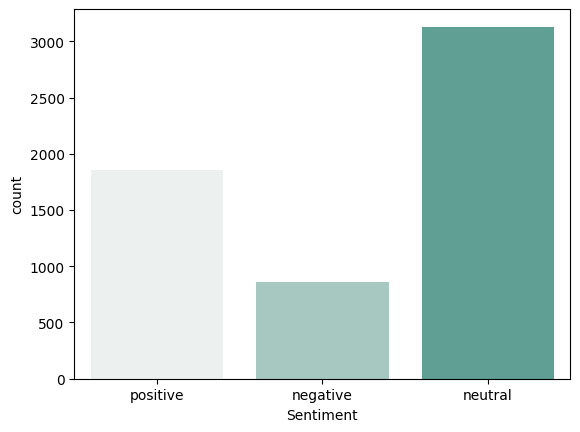

In [19]:
sns.countplot(data=df, x='Sentiment', palette='light:#5A9')

In [20]:
df['Sentiment'].value_counts()

Sentiment
neutral     3130
positive    1852
negative     860
Name: count, dtype: int64

So we have total of 5842 records of which - 
<br>Neutral records are 3130 - <b>53.57% </b>
<br>Positive records are 1852 - <b>31.7% </b>
<br>negative records are 860 - <b>14.72% </b>

# 4. 🛠️ Feature Engineering (Text Preprocessing)

In [21]:
nlp = spacy.load('en_core_web_sm')
stop_words = nlp.Defaults.stop_words

OSError: [E050] Can't find model 'en_core_web_sm'. It doesn't seem to be a Python package or a valid path to a data directory.

In [22]:
import gensim.downloader as api
print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


These are all the Word2Vec pretrained models available in gensim library. We will use <b>'word2vec-google-news-300'</b> model to convert our words to vectors. The dimension of each vectors will be 300x1. 

In [23]:
wv = api.load('word2vec-google-news-300')

[=================================-----------------] 66.7% 1109.3/1662.8MB downloaded

KeyboardInterrupt: 

In [ ]:
print(type(wv))

Now we are going to define a function called 'sent_vec()'. The purpose of this function is to convert all the words in a sentance into vectors and take average of all these vectors so that the dimension of all the sentences is 300x1.

In [ ]:
def sent_vec(sent):
    vector_size = wv.vector_size
    wv_res = np.zeros(vector_size)
    count = 1
    for word in sent:
        if word in wv:
            count+=1
            wv_res = wv[word]
    wv_res = wv_res/count # taking the average
    return wv_res

Next, we define a function called 'preprocess()' to do pre-processing works like, stopword removal, converting to tokens, removing special characters, etc., from the input sentences.

In [ ]:
def preprocess(sentence):
    # Removing the numbers, special characters, etc from the sentence and replacing them with " "
    sentence = re.sub('[^a-zA-Z]',' ',sentence)
    # Converting sentence into a spacy doc - which is a sequence of tokens
    doc = nlp(sentence)
    # Lemmatization and lower casing the words
    tokens = [word.lemma_.lower().strip() for word in doc]
    # Removing stop words and punctuations
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

In [ ]:
# Step-1 : Converting Sentences into tokens
df['tokens'] = df['Sentence'].apply(preprocess)
df.head()

In [ ]:
# Step-2 : Converting each record into 300x1 dimension vector
df['vectors'] = df['tokens'].apply(sent_vec)
df.head()

In [ ]:
df['vectors'][0].shape

Now we define a function called 'convert_to_num()' to convert the output feature i.e., Sentiment column into numbers.

In [ ]:
def convert_to_num(record):
    if record == 'positive':
        return 1
    elif record == 'negative':
        return 2
    else:
        return 0

In [ ]:
df['Sentiment'] = df['Sentiment'].apply(convert_to_num)
df.head()

In [ ]:
X = df['vectors'].to_list()
y = df['Sentiment'].to_list()

In [ ]:
# Spliting into training and testing set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.20, random_state=0)

# 5. ⏳ Model Training

In [ ]:
models = {
    "Logistic Regression" : LogisticRegression(),
    "SVM" : SVC(),
    "Naive Bayes" : GaussianNB(),
    "Decision Tree" : DecisionTreeClassifier(),
    "Random Forest" : RandomForestClassifier(),
    "KNN" : KNeighborsClassifier(),
    "SGD" : SGDClassifier(),
    "XgBoost" : XGBClassifier(),
    "AdaBoost" : AdaBoostClassifier(),
    "CatBoost" : CatBoostClassifier(),
    "Gradient Boosting" : GradientBoostingClassifier()
}

In [ ]:
params = {
    "Logistic Regression" : {
        "C" : [100, 10, 1.0, 0.1, 0.01],
        "penalty" : ['l1', 'l2']
    },
    "SVM" : {
        "C" : [0.1, 1, 10, 100, 1000], 
        "gamma" : [1, 0.1, 0.01, 0.001, 0.0001],
        "kernel" : ['rbf']
    },
    "Naive Bayes" : {
        "var_smoothing" : np.logspace(0,-9, num=100)
    },
    "Decision Tree" : {
        "max_depth" : [3, 4, 5, 10, 15]
    },
    "Random Forest" : {
        "n_estimators" : [100, 200, 300, 400],
        "max_depth" : [3, 5, 10],
        "min_samples_leaf" : [1, 2, 4]
    },
    "KNN" : {
        'n_neighbors' : [5, 7, 9, 11, 13, 15],
        'weights' : ['uniform', 'distance'],
        'metric' : ['minkowski', 'euclidean', 'manhattan']
    },
    "SGD" : {
        "penalty" : ['l1', 'l2', 'elasticnet'],
        "alpha" : [0.0001, 0.001, 0.01, 0.1]
    },
    "XgBoost" : {
        "learning_rate" : [0.001, 0.01, 0.1, 1]
    },
    "AdaBoost" : {
        "learning_rate" : [0.001, 0.01, 0.1, 1]
    },
    "CatBoost" : {
        "learning_rate" : [0.001, 0.01, 0.1, 1]
    },
    "Gradient Boosting" : {
        "learning_rate" : [0.001, 0.01, 0.1, 1],
        "n_estimators" : [100, 200]
    }
}

Now we will define a function which will take all the hyperparamerters and all the models and fits it to the training set and returns a report which has the testing accuracy of all the combinations of models. From that report we will choose the one with the top accuracy.

In [ ]:
def evaluate_models(X_train, y_train, X_test, y_test, models, param):
    report = {}
    for i in range(len(list(models))):
        model = list(models.values())[i]
        para = param[list(models.keys())[i]]

        gs = GridSearchCV(model, para, cv=3)
        gs.fit(X_train, y_train)

        model.set_params(**gs.best_params_)
        model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        train_model_score = accuracy_score(y_train, y_train_pred)
        test_model_score = accuracy_score(y_test, y_test_pred)

        report[list(models.keys())[i]] = test_model_score

    return report

In [ ]:
model_report: dict = evaluate_models(
                X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, models=models, param=params)

Model training took more than 1 hour. So, I have saved the best model.

In [ ]:
# Model Report Containing the accuracies of all the models
print(model_report)

Looking at the accuracy of the model we can say it's not the best model. But we can still make it more accurate by trying some more sets of hyperparameters.

In [ ]:
# To get best model score from dict
best_model_score = max(sorted(model_report.values()))
# To get best model name from dict
best_model_name = list(model_report.keys())[
    list(model_report.values()).index(best_model_score)
]
best_model = models[best_model_name]
print(best_model)

In [ ]:
# Predicting with the best model
y_pred = best_model.predict(X_test)

In [ ]:
# Accuracy of the best model
accuracy_score(y_test, y_pred)

In [ ]:
# Confusion Matrix of the Best Model
confusion_matrix(y_test, y_pred)

In [ ]:
# Saving the model
# save the model to disk
filename = 'finalized_model.pickle'
pickle.dump(best_model, open(filename, 'wb'))

# 6. 🔎 Predicting on New Data

In [ ]:
input = "In last year , Companies net sales did not increase , while it moved to a zero pre-tax profit from a pre-tax loss of 4 million ."

In [ ]:
preprocessed_input = preprocess(input)
vector_input = sent_vec(preprocessed_input)

In [ ]:
# load the saved model if you want
# loaded_model = pickle.load(open(filename, "rb"))
pout = best_model.predict(vector_input)
output = 'positive' if pout==1 else 'neutral' if pout==0 else 'negative'
print(output)

# If you like Please Upvote 📈